# African WildLife Classification



This Colab notebook provides a streamlined workflow for training a CNN model model to classify African WildLife Animals.   

**Objective**: To solidify understanding of training parameter tuning for optimal image classification accuracy on the African Wildlife dataset, while maintaining a fixed CNN architecture.

**Dataset**: (Use the same dataset from the original contest)

**Task**: You will progressively tune the training parameters of a fixed baseline CNN model in Keras to achieve higher accuracy. You will submit five trained models, each representing a step in your tuning process.

## Step 1: Libraries
Run this cell but do not modify it

In [ ]:
import h5py                     # Hierarchical data format
import cv2                      # Reading and writing images
import numpy as np              # Numpy library
import matplotlib.pyplot as plt # Visualization library
import tensorflow as tf         # Tensorflor library
import os                       # Operating system
import math
import urllib.request
from sklearn.metrics import confusion_matrix


import seaborn as sns;          # Visualization library
sns.set()
sns.set(style="white")
sns.set(style="whitegrid", color_codes = True)

In [ ]:
# Displays a confusion matrix
def plot_heatmap(y_true, y_pred, class_names, title, ylabel, xlabel):
    fig, (ax) = plt.subplots(1, 1, figsize=(10, 10))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="right")
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_xlabel(xlabel, fontsize=12)
    fig.tight_layout()
    fig.subplots_adjust(top=1.25)
    plt.show()

In [ ]:
# This function displays images and their corresponding ground truth and
# predicted labels.
def display_predictions( images, labels, classnames, predicted_classes, max_display_images, border=1):

  # set the number of images to display
  numbers_to_display = min(labels.shape[0], max_display_images)

  # select random indices.
  indices = np.random.choice(len(images), size=numbers_to_display, replace=False)

  num_cells = math.ceil(math.sqrt(numbers_to_display))
  plt.figure(figsize=(10, 10))

  for plot_index in range(numbers_to_display):

      # select an index
      item_index = indices[ plot_index ]

      # retrieve the label at the selected index
      predicted_label = predicted_classes[item_index]

      # retrieve the image at the selected index
      img = images[item_index,:,:,:]

      # create a subplot tao draw the image
      ax = plt.subplot(num_cells, num_cells, plot_index + 1)

      # disable ticks and grid
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)

      # determine border color
      color = 'white'
      if predicted_label == labels[item_index]:
        color = 'green'
      else:
        color = 'red'

      # set border width
      ax.spines['bottom'].set_linewidth(border)
      ax.spines['top'].set_linewidth(border)
      ax.spines['right'].set_linewidth(border)
      ax.spines['left'].set_linewidth(border)

      # set border color
      ax.spines['bottom'].set_color(color)
      ax.spines['top'].set_color(color)
      ax.spines['right'].set_color(color)
      ax.spines['left'].set_color(color)

      # display the image
      plt.imshow(img)

      # display the corresponding label
      plt.xlabel(classnames[ predicted_label ])

  plt.subplots_adjust(hspace=0.5, wspace=0.5)
  plt.show()

## Step 2: Google Drive
Run this cell and update the paths to match your Google Drive folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Replace the following variable with the exact path to your starter code folder.
path_experiment_folder = '/content/drive/MyDrive/Computer Vision/African Wildlife Classification/Starter02'

# Path to your training data
path_train_data = os.path.join(path_experiment_folder, 'Data', 'train_data.h5')

# Path to your vakudatuib data
path_valid_data = os.path.join(path_experiment_folder, 'Data', 'valid_data.h5')

## Step 3: Data

Run this cell but do not modify it

In [ ]:
# Load training data
train_images = []
train_labels = []

with h5py.File(path_train_data, "r") as f:
  train_images = f['images'][:]
  train_labels = f['labels'][:]
  classnames = f['classnames'][:]
  classnames = [b.decode('utf-8') for b in classnames]

In [ ]:
# Load validation data
valid_images = []
valid_labels = []

with h5py.File(path_valid_data, "r") as f:
  valid_images = f['images'][:]
  valid_labels = f['labels'][:]

In [ ]:
# Normalize the data
train_images = train_images/255.0
valid_images = valid_images/255.0

In [ ]:
# confirm the sizes of the data
print('Train set images: ', train_images.shape, 'labels: ', train_labels.shape )
print('Validation set images: ', valid_images.shape, 'labels: ', valid_labels.shape )
print('Classes:', classnames)

Train set images:  (1049, 128, 128, 3) labels:  (1049,)
Validation set images:  (225, 128, 128, 3) labels:  (225,)
Classes: ['Buffalo', 'Elephant', 'Rhino', 'Zebra']


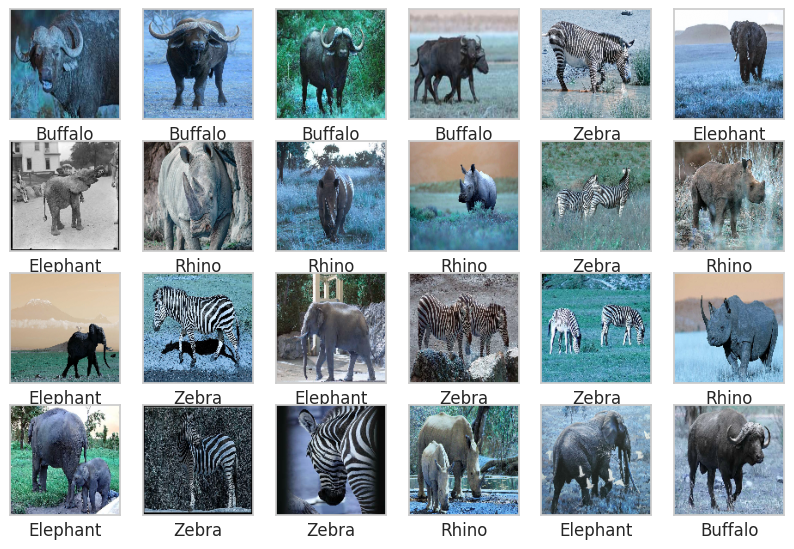

In [ ]:
# visualize training examples

# The number of images to visualize
num_images_to_display = 24

# Select random indices from the image array
indices = np.random.choice(train_images.shape[0], num_images_to_display)

# Visualize the images
plt.figure(figsize=(10,10))
for i in range(num_images_to_display):
    index = indices[i]
    label = train_labels[index]
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[index])
    plt.xlabel( classnames[label] )
plt.show()

## Step 4: Model
Run this cell but do not modify it

In [ ]:
# Define and create your model
def create_cnn(input_shape, num_classes):

  # Create the model
  model = tf.keras.models.Sequential()

  # Add the input layer, which accepts images of the
  # same dimension as our training images
  model.add(tf.keras.layers.Input(shape=input_shape))

  # data_augmentation = tf.keras.Sequential([
  #     tf.keras.layers.RandomBrightness(factor=0.2),
  #     tf.keras.layers.RandomContrast(factor=0.2),
  # ])

  # # Add data augmentation
  # model.add(data_augmentation)

  # Add the first convolution layer consisting of 32 filters
  # of size (5,5). It uses the ReLU activation function and a padding of 'same'
  # to preserve the size of the input.
  model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same'))

  # Add a maxpooling to downsample the output of the convolution layer by a (2,2) filter
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))

  # Add the second convolution layer consisting of 64 filters
  # of size (3,35). It uses the ReLU activation function and a padding of 'same'
  # to preserve the size of the input.
  model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'))

  # Add a maxpooling to downsample the output of the convolution layer by a (2,2) filter
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))

  # Add the third convolution layer consisting of 128 filters
  # of size (3,3). It uses the ReLU activation function and a padding of 'same'
  # to preserve the size of the input.
  model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))

  # Add a maxpooling to downsample the output of the convolution layer by a (2,2) filter
  model.add(tf.keras.layers.MaxPooling2D((2, 2)))

  # Flatten the feature maps into a linear vector for the fully-connected layers
  model.add(tf.keras.layers.Flatten())

  # Add a dropout layer to prevent overfitting.
  # The percentage represents the probability that a specific neuron will
  # be randomly dropped out during the training phase of the neural network.
  model.add(tf.keras.layers.Dropout(0.5))

  # Add a softmax layer to output a probability map for the 6 classes
  model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

  return model

## Step 5: Baseline (Default Training Parameters)

Make the following changes and run this cell to train your baseline model.

*   **Loss**: sparse categorical crossentropy
*   **Optimizer**: Adam (learning rate 0.0001)
*   **Batch size**: 32
*   **Epochs**: 10

In [ ]:
# create the model
model = create_cnn( input_shape = train_images.shape[1:], num_classes=len(classnames) )

# Create learning reate for the optimizer
INITIAL_LEARNING_RATE = 0.001

# assert statement verifies the value is indeed 0.001.
assert INITIAL_LEARNING_RATE == 0.001, f"INITIAL_LEARNING_RATE {INITIAL_LEARNING_RATE} is no t0.0001"

# Adam (Adaptive Moment Estimation):
# - A popular and efficient optimization algorithm.
# - It combines the advantages of AdaGrad and RMSProp.
# - It adapts the learning rate for each parameter based on its historical gradients.
# - It uses both the first moment (mean) and the second moment (variance) of the gradients.
# - Often performs well with default parameters and is robust to hyperparameter choices.
# - learning_rate: controls the step size during optimization.
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE)

# Adam (Adaptive Moment Estimation):
# - A popular and efficient optimization algorithm.
# - It combines the advantages of AdaGrad and RMSProp.
# - It adapts the learning rate for each parameter based on its historical gradients.
# - It uses both the first moment (mean) and the second moment (variance) of the gradients.
# - Often performs well with default parameters and is robust to hyperparameter choices.
# - learning_rate: controls the step size during optimization.
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE)

# LOSS FUNCTION
# sparse_categorical_crossentropy in Keras is a loss function used
# for multi-class classification when your labels are integers
# (not one-hot encoded). It efficiently calculates the
# cross-entropy loss between predicted probabilities and integer
# labels, optimizing for scenarios where each input belongs to
# a single class. This avoids the overhead of one-hot encoding,
# making it memory-efficient and computationally faster, particularly
# when dealing with a large number of classes.
LOSS = 'sparse_categorical_crossentropy'

# METRIC
# The accuracy metric in Keras' model.compile measures the proportion
# of correctly classified samples during training and evaluation.
# For classification tasks, it calculates how often the model's
# predictions match the true labels, providing a straightforward
# way to assess the model's performance.
METRICS = ['accuracy']

# Configures the model for training
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

# Model path
path_model = os.path.join(path_experiment_folder, 'Model', 'model_baseline.keras')

# Callback for saving model
# Saves the model with the highest validation accuracy.
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=path_model, # Path to save the best model
    monitor='val_accuracy',
    save_best_only=True, # Save only the best model
    verbose=1
)

# Callbacks
# a list of callback functions that are executed at various stages of
# the training process. These callbacks allow you to customize training
# behavior, such as early stopping, model checkpointing, learning rate scheduling,
# and logging, by providing hooks into the training loop.
CALLBACKS = [ checkpoint ]

# EPOCHS
# The epochs parameter specifies the number of complete passes through
# the entire training dataset. Each epoch represents one full cycle
# of training, where the model updates its weights based on the
# training data. More epochs allow the model to learn more patterns,
# but can also lead to overfitting if not managed carefully.
EPOCHS = 15

assert EPOCHS == 15, f"EPOCHS {EPOCHS} is not 10."

# BATCH SIZE
# The batch_size parameter in Keras' model.fit determines how
# many samples are processed before the model's weights are updated.
# It controls the granularity of gradient updates, affecting training
# speed and memory usage. Smaller batches provide more frequent updates
# but can be noisy, while larger batches are more stable but might slow down learning.
BATCH_SIZE = 28

assert BATCH_SIZE == 28, f"BATCH_SIZE {BATCH_SIZE} is not 320."


# Trains the model and validates it.
history = model.fit(train_images,
                    train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=2,           # level ouf output to proint
                    callbacks=CALLBACKS,       # callbacks
                    validation_data=(valid_images, valid_labels)) # test features and labels

Epoch 1/15

Epoch 1: val_accuracy improved from -inf to 0.54222, saving model to /content/drive/MyDrive/Computer Vision/African Wildlife Classification/Starter02/Model/model_baseline.keras
38/38 - 20s - 533ms/step - accuracy: 0.4280 - loss: 1.2359 - val_accuracy: 0.5422 - val_loss: 1.0728
Epoch 2/15

Epoch 2: val_accuracy improved from 0.54222 to 0.56444, saving model to /content/drive/MyDrive/Computer Vision/African Wildlife Classification/Starter02/Model/model_baseline.keras
38/38 - 19s - 497ms/step - accuracy: 0.6235 - loss: 0.9148 - val_accuracy: 0.5644 - val_loss: 0.9610
Epoch 3/15

Epoch 3: val_accuracy improved from 0.56444 to 0.63111, saving model to /content/drive/MyDrive/Computer Vision/African Wildlife Classification/Starter02/Model/model_baseline.keras
38/38 - 17s - 453ms/step - accuracy: 0.6683 - loss: 0.7790 - val_accuracy: 0.6311 - val_loss: 0.8845
Epoch 4/15

Epoch 4: val_accuracy improved from 0.63111 to 0.65333, saving model to /content/drive/MyDrive/Computer Vision/A

### 5.1 - Training

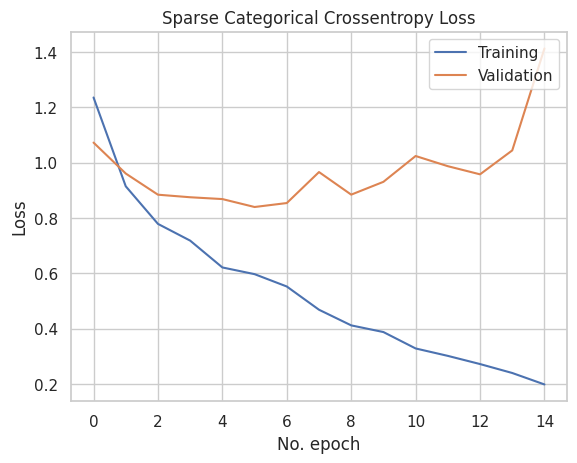

In [ ]:
# Visualize the training and test loss
# The graph of the loss should show the loss of the
# network decreasing as the training progresses.
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Sparse Categorical Crossentropy Loss')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

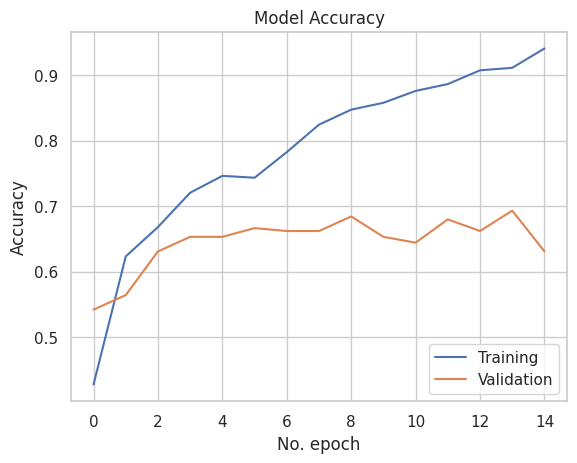

In [ ]:
# Visualize the training and test accuracy
# The graph of the accuracy should show the accuracy of the
# network increasing as the training progresses.
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
plt.show()

### 5.2 - Evaluation

In [ ]:
# Model path
path_model = os.path.join(path_experiment_folder, 'Model', 'model_baseline.keras')

# Load saved model
loaded_model = tf.keras.models.load_model( path_model )

In [ ]:
# Evaluate the model on the entire test dataset
# to determine its accuracy on unseen data
test_loss, test_acc = loaded_model.evaluate(valid_images, valid_labels)
print('Test accuracy: {:2.2f}%'.format(test_acc*100))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.6821 - loss: 1.0638
Test accuracy: 69.33%


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step


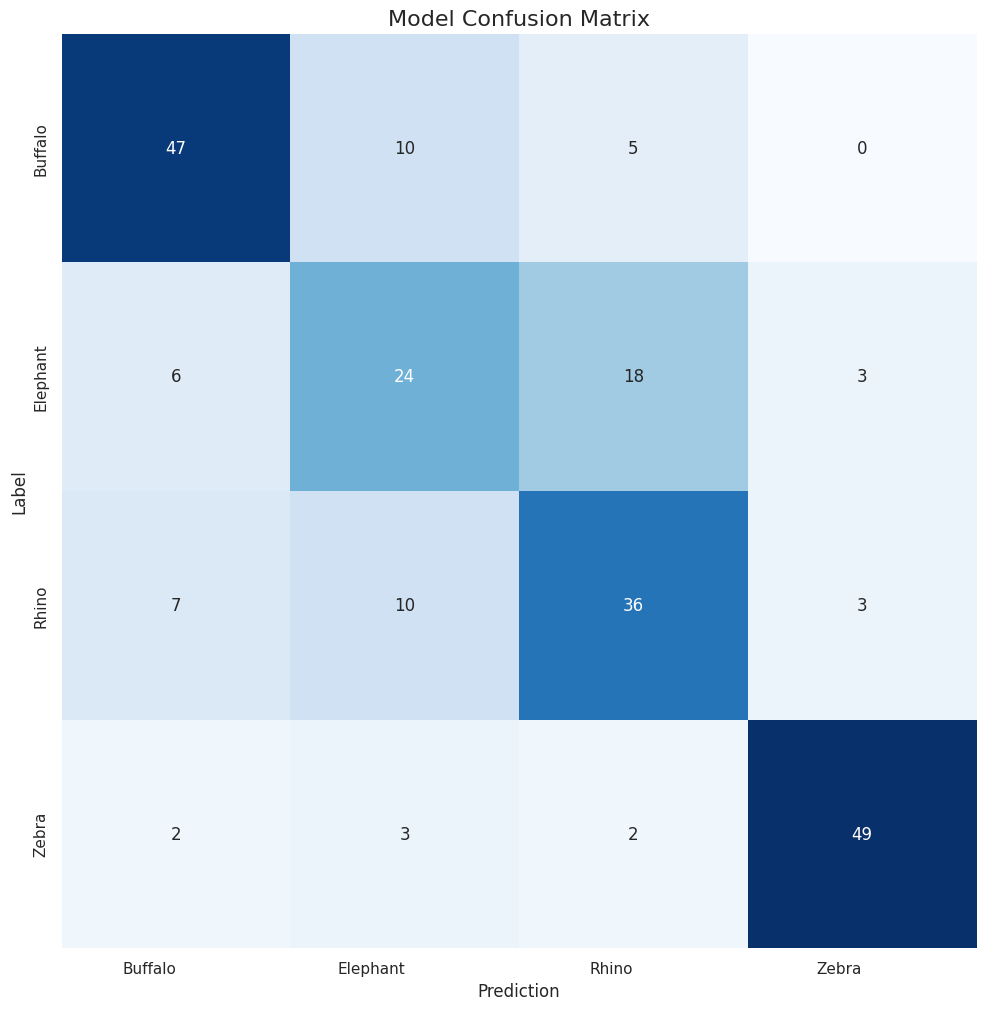

In [ ]:
# Make predictions on the test dataset
predictions = loaded_model.predict(valid_images)

# Convert the probability map to class labels
pred_classes = np.argmax(predictions,axis=1)

# Display the confusion matrix
plot_heatmap(valid_labels, pred_classes, classnames, title="Model Confusion Matrix", ylabel='Label', xlabel='Prediction')

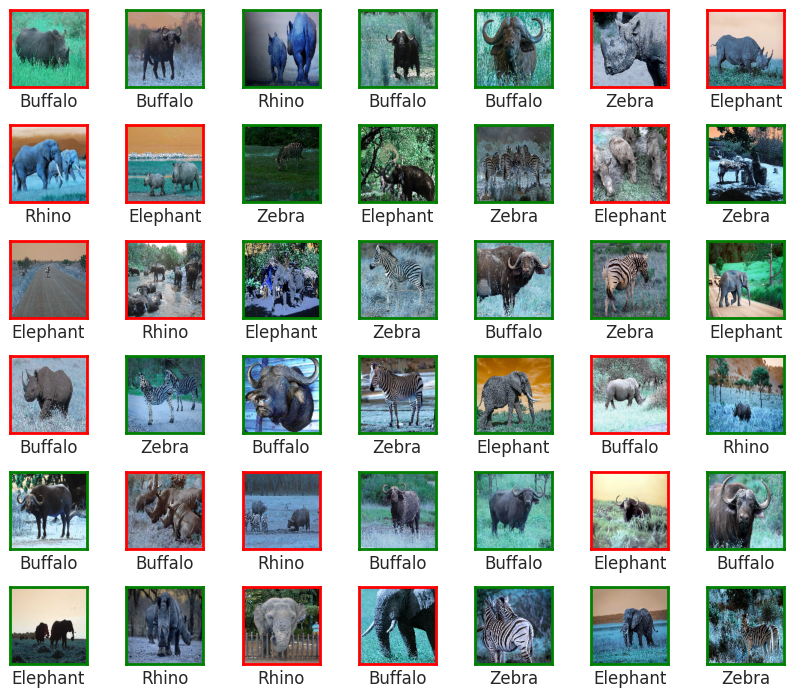

In [ ]:
# Display predictions from our model.
# Correct predictions are rendered with green border, and incorrect
# predictions are rendered with red border.
display_predictions(valid_images, valid_labels, classnames, pred_classes, 42, border=2)

## Step 6: Batch Size and Epoch Tuning

Tune the following hyperparameters and run this cell to train your model

*   **Parameter to Tune**: Batch size
    * Try batch sizes between 32 and 64
*   **Parameter to Tune**: Epochs
    * Try epochs between 20 or 30 epochs

### 5.1 - Training

In [ ]:
# create the model
model = create_cnn( input_shape = train_images.shape[1:], num_classes=len(classnames) )

# Create learning reate for the optimizer
INITIAL_LEARNING_RATE = 0.0001

# Adam (Adaptive Moment Estimation):
# - A popular and efficient optimization algorithm.
# - It combines the advantages of AdaGrad and RMSProp.
# - It adapts the learning rate for each parameter based on its historical gradients.
# - It uses both the first moment (mean) and the second moment (variance) of the gradients.
# - Often performs well with default parameters and is robust to hyperparameter choices.
# - learning_rate: controls the step size during optimization.
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE)

# LOSS FUNCTION
# sparse_categorical_crossentropy in Keras is a loss function used
# for multi-class classification when your labels are integers
# (not one-hot encoded). It efficiently calculates the
# cross-entropy loss between predicted probabilities and integer
# labels, optimizing for scenarios where each input belongs to
# a single class. This avoids the overhead of one-hot encoding,
# making it memory-efficient and computationally faster, particularly
# when dealing with a large number of classes.
LOSS = 'sparse_categorical_crossentropy'

# METRIC
# The accuracy metric in Keras' model.compile measures the proportion
# of correctly classified samples during training and evaluation.
# For classification tasks, it calculates how often the model's
# predictions match the true labels, providing a straightforward
# way to assess the model's performance.
METRICS = ['accuracy']

# Configures the model for training
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

# Model path
path_model = os.path.join(path_experiment_folder, 'Model', 'model_batchepoch.keras')

# Callback for saving model
# Saves the model with the highest validation accuracy.
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=path_model, # Path to save the best model
    monitor='val_accuracy',
    save_best_only=True, # Save only the best model
    verbose=1
)

# Callbacks
# a list of callback functions that are executed at various stages of
# the training process. These callbacks allow you to customize training
# behavior, such as early stopping, model checkpointing, learning rate scheduling,
# and logging, by providing hooks into the training loop.
CALLBACKS = [ checkpoint ]

# EPOCHS
# The epochs parameter specifies the number of complete passes through
# the entire training dataset. Each epoch represents one full cycle
# of training, where the model updates its weights based on the
# training data. More epochs allow the model to learn more patterns,
# but can also lead to overfitting if not managed carefully.
EPOCHS = 21

assert 21 <= EPOCHS <= 21, f"EPOCHS {EPOCHS} is not between 20 and 30."

# BATCH SIZE
# The batch_size parameter in Keras' model.fit determines how
# many samples are processed before the model's weights are updated.
# It controls the granularity of gradient updates, affecting training
# speed and memory usage. Smaller batches provide more frequent updates
# but can be noisy, while larger batches are more stable but might slow down learning.
BATCH_SIZE = 39

assert 39 <= BATCH_SIZE <= 39, f"BATCH_SIZE {BATCH_SIZE} is not between 20 and 30."


# Trains the model and validates it.
history = model.fit(train_images,
                    train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=2,           # level ouf output to proint
                    callbacks=CALLBACKS,       # callbacks
                    validation_data=(valid_images, valid_labels)) # test features and labels

Epoch 1/21

Epoch 1: val_accuracy improved from -inf to 0.45333, saving model to /content/drive/MyDrive/Computer Vision/African Wildlife Classification/Starter02/Model/model_batchepoch.keras
27/27 - 19s - 693ms/step - accuracy: 0.2698 - loss: 1.3836 - val_accuracy: 0.4533 - val_loss: 1.3635
Epoch 2/21

Epoch 2: val_accuracy improved from 0.45333 to 0.47111, saving model to /content/drive/MyDrive/Computer Vision/African Wildlife Classification/Starter02/Model/model_batchepoch.keras
27/27 - 17s - 625ms/step - accuracy: 0.3804 - loss: 1.3412 - val_accuracy: 0.4711 - val_loss: 1.3254
Epoch 3/21

Epoch 3: val_accuracy improved from 0.47111 to 0.51111, saving model to /content/drive/MyDrive/Computer Vision/African Wildlife Classification/Starter02/Model/model_batchepoch.keras
27/27 - 21s - 783ms/step - accuracy: 0.4461 - loss: 1.2886 - val_accuracy: 0.5111 - val_loss: 1.2710
Epoch 4/21

Epoch 4: val_accuracy improved from 0.51111 to 0.54667, saving model to /content/drive/MyDrive/Computer Vi

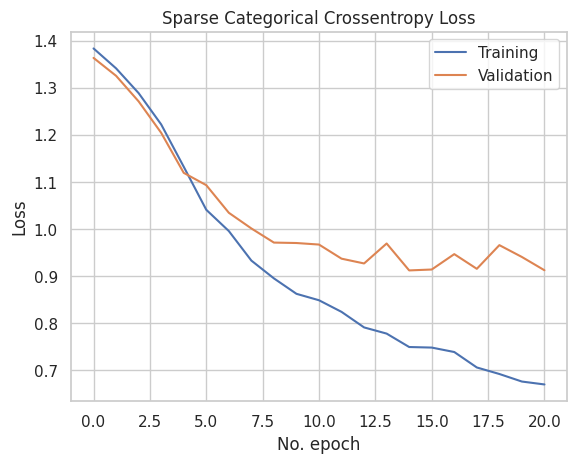

In [ ]:
# Visualize the training and test loss
# The graph of the loss should show the loss of the
# network decreasing as the training progresses.
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Sparse Categorical Crossentropy Loss')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

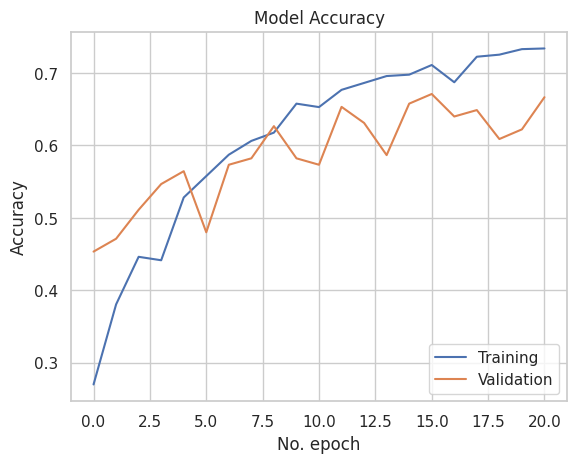

In [ ]:
# Visualize the training and test accuracy
# The graph of the accuracy should show the accuracy of the
# network increasing as the training progresses.
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
plt.show()

### 5.2 - Evaluation

In [ ]:
# Model path
path_model = os.path.join(path_experiment_folder, 'Model', 'model_batchepoch.keras')

# Load saved model
loaded_model = tf.keras.models.load_model( path_model )

In [ ]:
# Evaluate the model on the entire test dataset
# to determine its accuracy on unseen data
test_loss, test_acc = loaded_model.evaluate(valid_images, valid_labels)
print('Test accuracy: {:2.2f}%'.format(test_acc*100))

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.6676 - loss: 0.9396
Test accuracy: 67.11%


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step


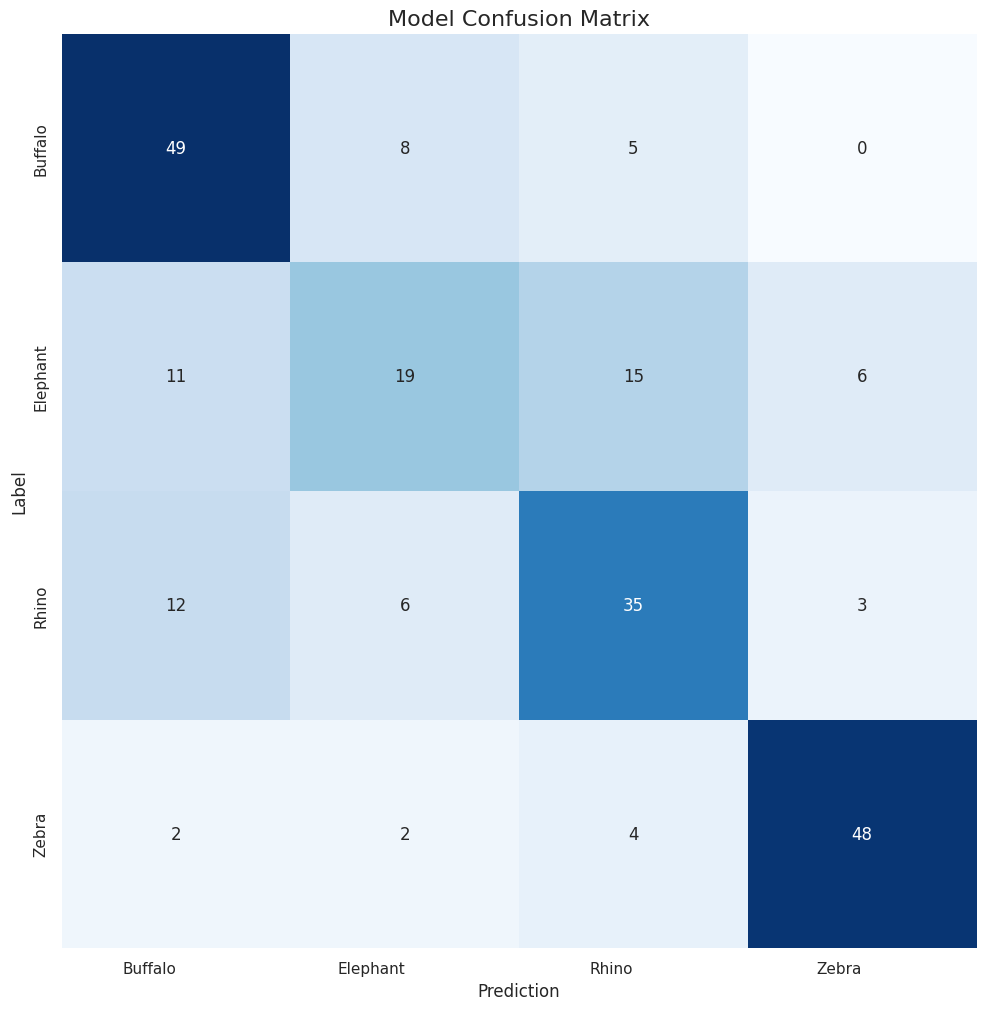

In [ ]:
# Make predictions on the test dataset
predictions = loaded_model.predict(valid_images)

# Convert the probability map to class labels
pred_classes = np.argmax(predictions,axis=1)

# Display the confusion matrix
plot_heatmap(valid_labels, pred_classes, classnames, title="Model Confusion Matrix", ylabel='Label', xlabel='Prediction')

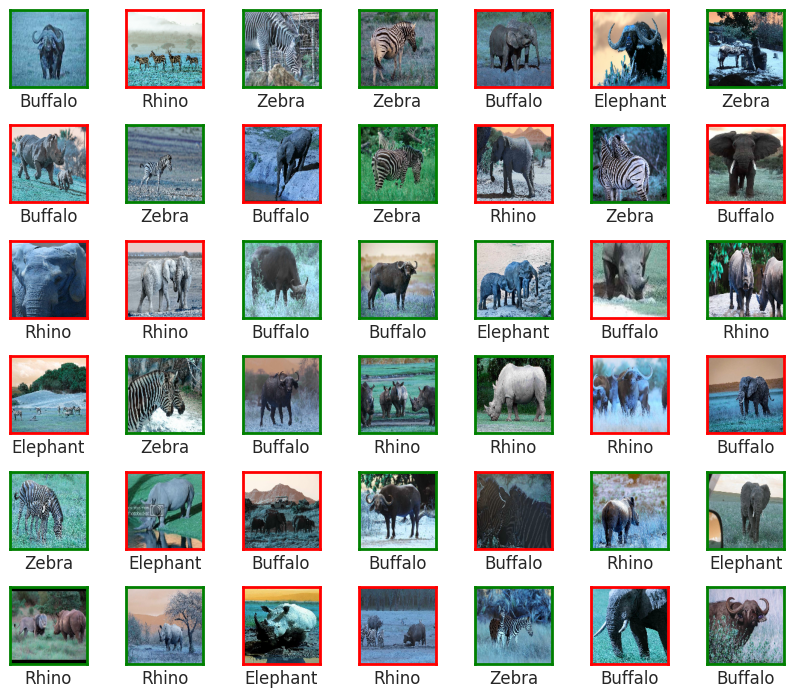

In [ ]:
# Display predictions from our model.
# Correct predictions are rendered with green border, and incorrect
# predictions are rendered with red border.
display_predictions(valid_images, valid_labels, classnames, pred_classes, 42, border=2)

## Step 7: Learning Rate Tuning

Tune the following hyperparameters and run this cell to train your model

* Parameter to Tune: Implement ReduceLROnPlateau callback.
  * Monitor validation loss, reduce learning rate by a factor of 0.1 - 0.5 if loss plateaus for 3 - 5 epochs.


### 5.1 - Training

In [145]:
# create the model
model = create_cnn( input_shape = train_images.shape[1:], num_classes=len(classnames) )

# Create learning reate for the optimizer
INITIAL_LEARNING_RATE = 0.0001

# Adam (Adaptive Moment Estimation):
# - A popular and efficient optimization algorithm.
# - It combines the advantages of AdaGrad and RMSProp.
# - It adapts the learning rate for each parameter based on its historical gradients.
# - It uses both the first moment (mean) and the second moment (variance) of the gradients.
# - Often performs well with default parameters and is robust to hyperparameter choices.
# - learning_rate: controls the step size during optimization.
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE)

# LOSS FUNCTION
# sparse_categorical_crossentropy in Keras is a loss function used
# for multi-class classification when your labels are integers
# (not one-hot encoded). It efficiently calculates the
# cross-entropy loss between predicted probabilities and integer
# labels, optimizing for scenarios where each input belongs to
# a single class. This avoids the overhead of one-hot encoding,
# making it memory-efficient and computationally faster, particularly
# when dealing with a large number of classes.
LOSS = 'sparse_categorical_crossentropy'

# METRIC
# The accuracy metric in Keras' model.compile measures the proportion
# of correctly classified samples during training and evaluation.
# For classification tasks, it calculates how often the model's
# predictions match the true labels, providing a straightforward
# way to assess the model's performance.
METRICS = ['accuracy']

# Configures the model for training
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

# Model path
path_model = os.path.join(path_experiment_folder, 'Model', 'model_learningrate.keras')

# Callback for saving model
# Saves the model with the highest validation accuracy.
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=path_model, # Path to save the best model
    monitor='val_accuracy',
    save_best_only=True, # Save only the best model
    verbose=1
)

# In Keras' ReduceLROnPlateau callback, the factor parameter specifies
# the learning rate reduction amount. When the monitored metric plateaus,
# the learning rate is multiplied by this factor, typically a value
# between 0 and 1, to decrease it. A smaller factor results in a
# more aggressive learning rate reduction.
LEARNING_RATE_FACTOR = 0.1

assert 0.1  <= LEARNING_RATE_FACTOR <= 0.5, f"LEARNING_RATE_FACTOR {LEARNING_RATE_FACTOR} is not between 0.1 and 0.5"

# The patience parameter in Keras' ReduceLROnPlateau callback specifies
# the number of epochs with no improvement in the monitored metric
#  (e.g., validation loss) before the learning rate is reduced.
LEARNING_RATE_PATIENCE = 3

assert 3 <= LEARNING_RATE_PATIENCE <= 3, f"LEARNING_RATE_PATIENCE {LEARNING_RATE_PATIENCE} is not between 3 and 5."

# Callback for earning Rate Adjustment
# Reduces learning rate when validation accuracy plateaus. Helps model escape local minima.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=LEARNING_RATE_FACTOR,
    patience=LEARNING_RATE_PATIENCE,
    min_lr=0.0001,
    verbose=1
)


# a list of callback functions that are executed at various stages of
# the training process. These callbacks allow you to customize training
# behavior, such as early stopping, model checkpointing, learning rate scheduling,
# and logging, by providing hooks into the training loop.
CALLBACKS = [ checkpoint, reduce_lr ]

# The epochs parameter specifies the number of complete passes through
# the entire training dataset. Each epoch represents one full cycle
# of training, where the model updates its weights based on the
# training data. More epochs allow the model to learn more patterns,
# but can also lead to overfitting if not managed carefully.
EPOCHS = 5

# The batch_size parameter in Keras' model.fit determines how
# many samples are processed before the model's weights are updated.
# It controls the granularity of gradient updates, affecting training
# speed and memory usage. Smaller batches provide more frequent updates
# but can be noisy, while larger batches are more stable but might slow down learning.
BATCH_SIZE = 32


# Trains the model and validates it.
history = model.fit(train_images,
                    train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=2,           # level ouf output to proint
                    callbacks=CALLBACKS,       # callbacks
                    validation_data=(valid_images, valid_labels)) # test features and labels

Epoch 1/5

Epoch 1: val_accuracy improved from -inf to 0.34222, saving model to /content/drive/MyDrive/Computer Vision/African Wildlife Classification/Starter02/Model/model_learningrate.keras
33/33 - 34s - 1s/step - accuracy: 0.2564 - loss: 1.3824 - val_accuracy: 0.3422 - val_loss: 1.3651 - learning_rate: 1.0000e-04
Epoch 2/5

Epoch 2: val_accuracy improved from 0.34222 to 0.42222, saving model to /content/drive/MyDrive/Computer Vision/African Wildlife Classification/Starter02/Model/model_learningrate.keras
33/33 - 27s - 804ms/step - accuracy: 0.4118 - loss: 1.3339 - val_accuracy: 0.4222 - val_loss: 1.3160 - learning_rate: 1.0000e-04
Epoch 3/5

Epoch 3: val_accuracy improved from 0.42222 to 0.50222, saving model to /content/drive/MyDrive/Computer Vision/African Wildlife Classification/Starter02/Model/model_learningrate.keras
33/33 - 20s - 609ms/step - accuracy: 0.4500 - loss: 1.2602 - val_accuracy: 0.5022 - val_loss: 1.2242 - learning_rate: 1.0000e-04
Epoch 4/5

Epoch 4: val_accuracy i

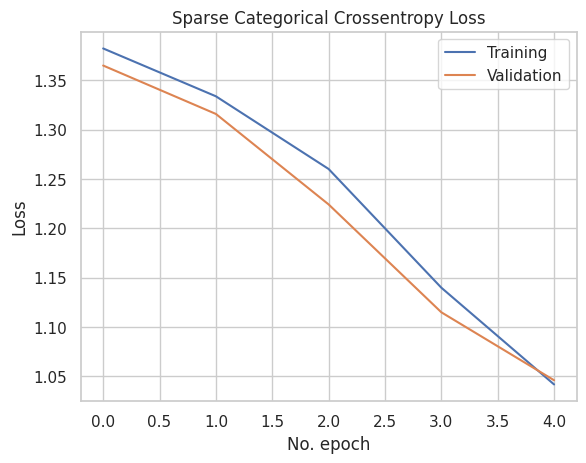

In [146]:
# Visualize the training and test loss
# The graph of the loss should show the loss of the
# network decreasing as the training progresses.
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Sparse Categorical Crossentropy Loss')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

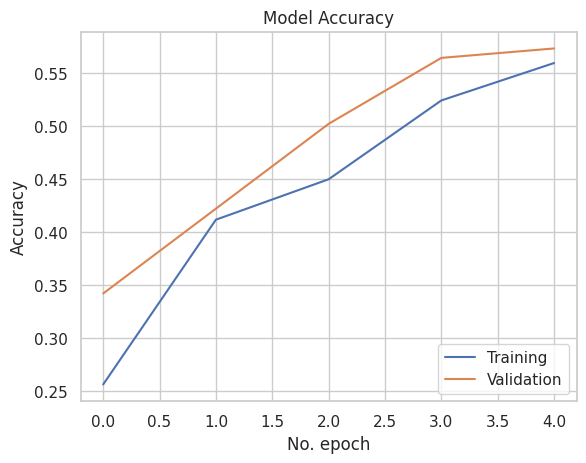

In [147]:
# Visualize the training and test accuracy
# The graph of the accuracy should show the accuracy of the
# network increasing as the training progresses.
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
plt.show()

### 5.2 - Evaluation

In [148]:
# Model path
path_model = os.path.join(path_experiment_folder, 'Model', 'model_learningrate.keras')

# Load saved model
loaded_model = tf.keras.models.load_model( path_model )

In [149]:
# Evaluate the model on the entire test dataset
# to determine its accuracy on unseen data
test_loss, test_acc = loaded_model.evaluate(valid_images, valid_labels)
print('Test accuracy: {:2.2f}%'.format(test_acc*100))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.5831 - loss: 1.0870
Test accuracy: 57.33%


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


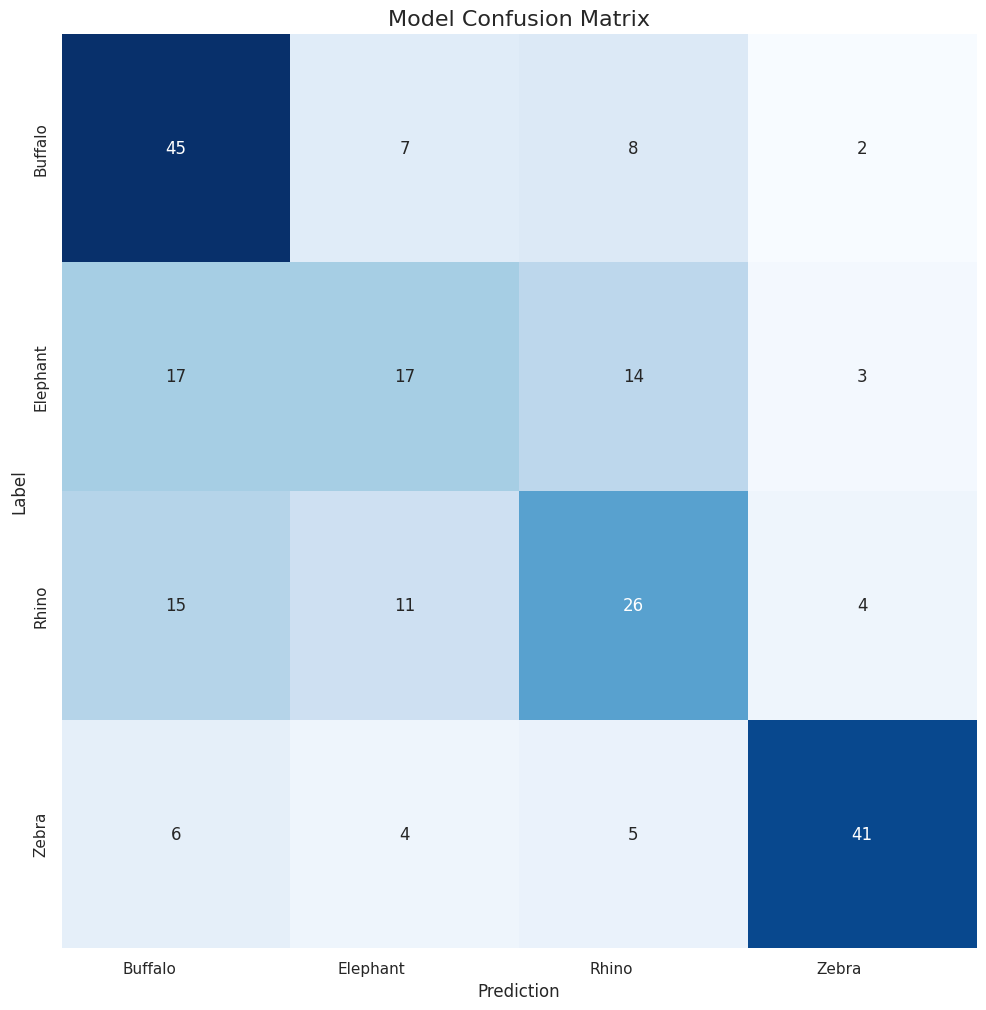

In [150]:
# Make predictions on the test dataset
predictions = loaded_model.predict(valid_images)

# Convert the probability map to class labels
pred_classes = np.argmax(predictions,axis=1)

# Display the confusion matrix
plot_heatmap(valid_labels, pred_classes, classnames, title="Model Confusion Matrix", ylabel='Label', xlabel='Prediction')

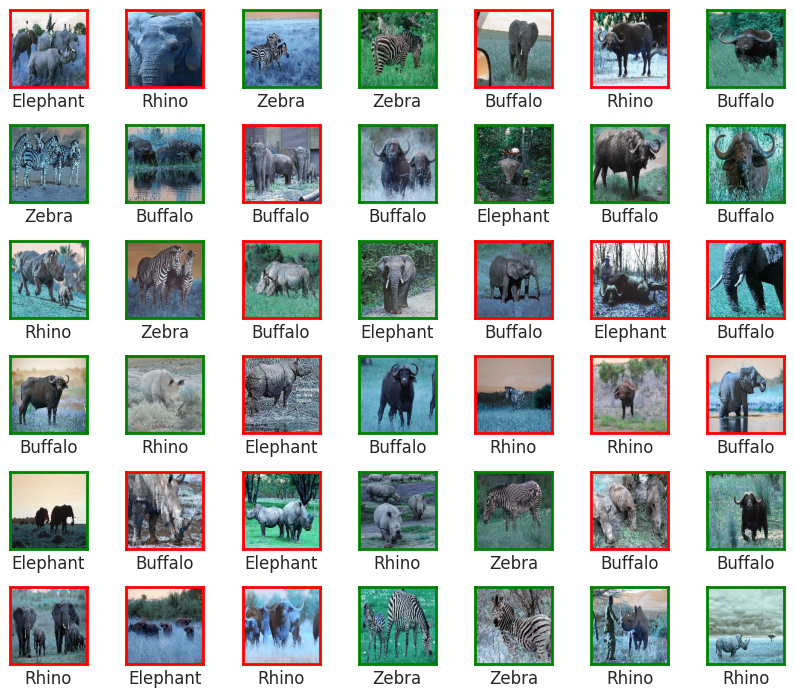

In [151]:
# Display predictions from our model.
# Correct predictions are rendered with green border, and incorrect
# predictions are rendered with red border.
display_predictions(valid_images, valid_labels, classnames, pred_classes, 42, border=2)

## Step 8: EarlyStopping and Final Tuning

Tune the following parametes and run the cell to train your model

*   Parameter to Tune: Implement EarlyStopping callback
    * Monitor validation loss, stop training if loss doesn't improve for 5-7

*   Parameter to Tune: Make final adjustments to learning rate or batch size based on observations from previous models.


In [136]:
path_model = os.path.join(path_experiment_folder, 'Model', 'model_final.keras')

### 5.1 - Training

In [168]:
# create the model
model = create_cnn( input_shape = train_images.shape[1:], num_classes=len(classnames) )

# Create learning reate for the optimizer
INITIAL_LEARNING_RATE = 0.0001

# Adam (Adaptive Moment Estimation):
# - A popular and efficient optimization algorithm.
# - It combines the advantages of AdaGrad and RMSProp.
# - It adapts the learning rate for each parameter based on its historical gradients.
# - It uses both the first moment (mean) and the second moment (variance) of the gradients.
# - Often performs well with default parameters and is robust to hyperparameter choices.
# - learning_rate: controls the step size during optimization.
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=INITIAL_LEARNING_RATE)

# LOSS FUNCTION
# sparse_categorical_crossentropy in Keras is a loss function used
# for multi-class classification when your labels are integers
# (not one-hot encoded). It efficiently calculates the
# cross-entropy loss between predicted probabilities and integer
# labels, optimizing for scenarios where each input belongs to
# a single class. This avoids the overhead of one-hot encoding,
# making it memory-efficient and computationally faster, particularly
# when dealing with a large number of classes.
LOSS = 'sparse_categorical_crossentropy'

# METRIC
# The accuracy metric in Keras' model.compile measures the proportion
# of correctly classified samples during training and evaluation.
# For classification tasks, it calculates how often the model's
# predictions match the true labels, providing a straightforward
# way to assess the model's performance.
METRICS = ['accuracy']

# Configures the model for training
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

# Model path
path_model = os.path.join(path_experiment_folder, 'Model', 'model_final.keras')

# Callback for saving model
# Saves the model with the highest validation accuracy.
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=path_model, # Path to save the best model
    monitor='val_accuracy',
    save_best_only=True, # Save only the best model
    verbose=1
)

# In Keras' ReduceLROnPlateau callback, the factor parameter specifies
# the learning rate reduction amount. When the monitored metric plateaus,
# the learning rate is multiplied by this factor, typically a value
# between 0 and 1, to decrease it. A smaller factor results in a
# more aggressive learning rate reduction.
LEARNING_RATE_FACTOR = 0.1

# The patience parameter in Keras' ReduceLROnPlateau callback specifies
# the number of epochs with no improvement in the monitored metric
#  (e.g., validation loss) before the learning rate is reduced.
LEARNING_RATE_PATIENCE = 3

# Callback for earning Rate Adjustment
# Reduces learning rate when validation accuracy plateaus. Helps model escape local minima.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=LEARNING_RATE_FACTOR,
    patience=LEARNING_RATE_PATIENCE,
    min_lr=0.00001,
    verbose=1
)

# Callback for Early Stopping
# Stops training when validation accuracy stops improving. Restores the best weights.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

# a list of callback functions that are executed at various stages of
# the training process. These callbacks allow you to customize training
# behavior, such as early stopping, model checkpointing, learning rate scheduling,
# and logging, by providing hooks into the training loop.
CALLBACKS = [ checkpoint, reduce_lr, early_stopping ]

# The epochs parameter specifies the number of complete passes through
# the entire training dataset. Each epoch represents one full cycle
# of training, where the model updates its weights based on the
# training data. More epochs allow the model to learn more patterns,
# but can also lead to overfitting if not managed carefully.
EPOCHS = 29

# The batch_size parameter in Keras' model.fit determines how
# many samples are processed before the model's weights are updated.
# It controls the granularity of gradient updates, affecting training
# speed and memory usage. Smaller batches provide more frequent updates
# but can be noisy, while larger batches are more stable but might slow down learning.
BATCH_SIZE = 32


# Trains the model and validates it.
history = model.fit(train_images,
                    train_labels,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    verbose=2,           # level ouf output to proint
                    callbacks=CALLBACKS,       # callbacks
                    validation_data=(valid_images, valid_labels)) # test features and labels

Epoch 1/29

Epoch 1: val_accuracy improved from -inf to 0.40889, saving model to /content/drive/MyDrive/Computer Vision/African Wildlife Classification/Starter02/Model/model_final.keras
33/33 - 19s - 565ms/step - accuracy: 0.2641 - loss: 1.3918 - val_accuracy: 0.4089 - val_loss: 1.3623 - learning_rate: 1.0000e-04
Epoch 2/29

Epoch 2: val_accuracy did not improve from 0.40889
33/33 - 16s - 499ms/step - accuracy: 0.3842 - loss: 1.3469 - val_accuracy: 0.3778 - val_loss: 1.3346 - learning_rate: 1.0000e-04
Epoch 3/29

Epoch 3: val_accuracy improved from 0.40889 to 0.47556, saving model to /content/drive/MyDrive/Computer Vision/African Wildlife Classification/Starter02/Model/model_final.keras
33/33 - 23s - 684ms/step - accuracy: 0.4652 - loss: 1.2875 - val_accuracy: 0.4756 - val_loss: 1.2589 - learning_rate: 1.0000e-04
Epoch 4/29

Epoch 4: val_accuracy improved from 0.47556 to 0.53333, saving model to /content/drive/MyDrive/Computer Vision/African Wildlife Classification/Starter02/Model/mode

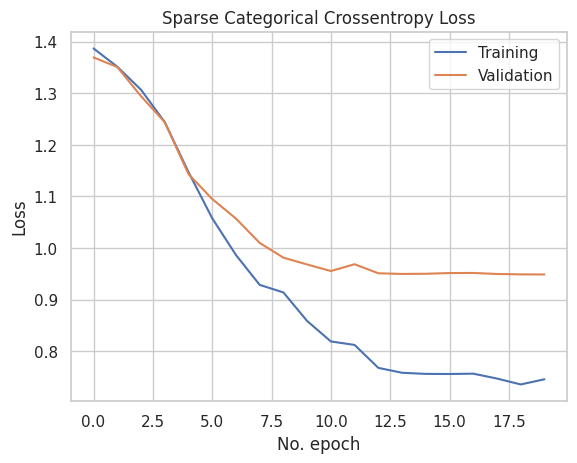

In [162]:
# Visualize the training and test loss
# The graph of the loss should show the loss of the
# network decreasing as the training progresses.
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Sparse Categorical Crossentropy Loss')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

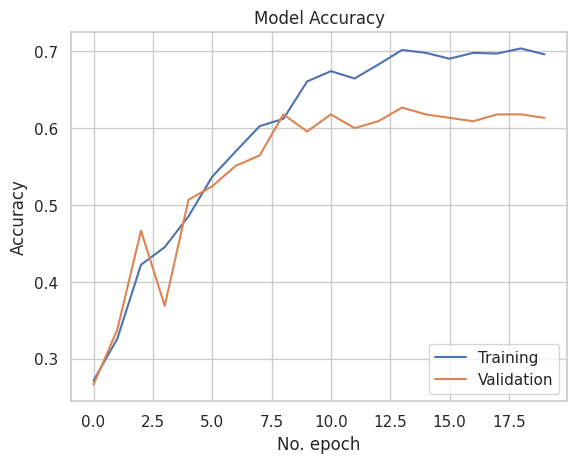

In [163]:
# Visualize the training and test accuracy
# The graph of the accuracy should show the accuracy of the
# network increasing as the training progresses.
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="lower right")
plt.show()

### 5.2 - Evaluation

In [164]:
# Model path
path_model = os.path.join(path_experiment_folder, 'Model', 'model_final.keras')

# Loading saved model
loaded_model = tf.keras.models.load_model( path_model )

In [165]:
# Evaluate the model on the entire test dataset
# to determine its accuracy on unseen data
test_loss, test_acc = loaded_model.evaluate(valid_images, valid_labels)
print('Test accuracy: {:2.2f}%'.format(test_acc*100))

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - accuracy: 0.6109 - loss: 0.9822
Test accuracy: 62.67%


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step


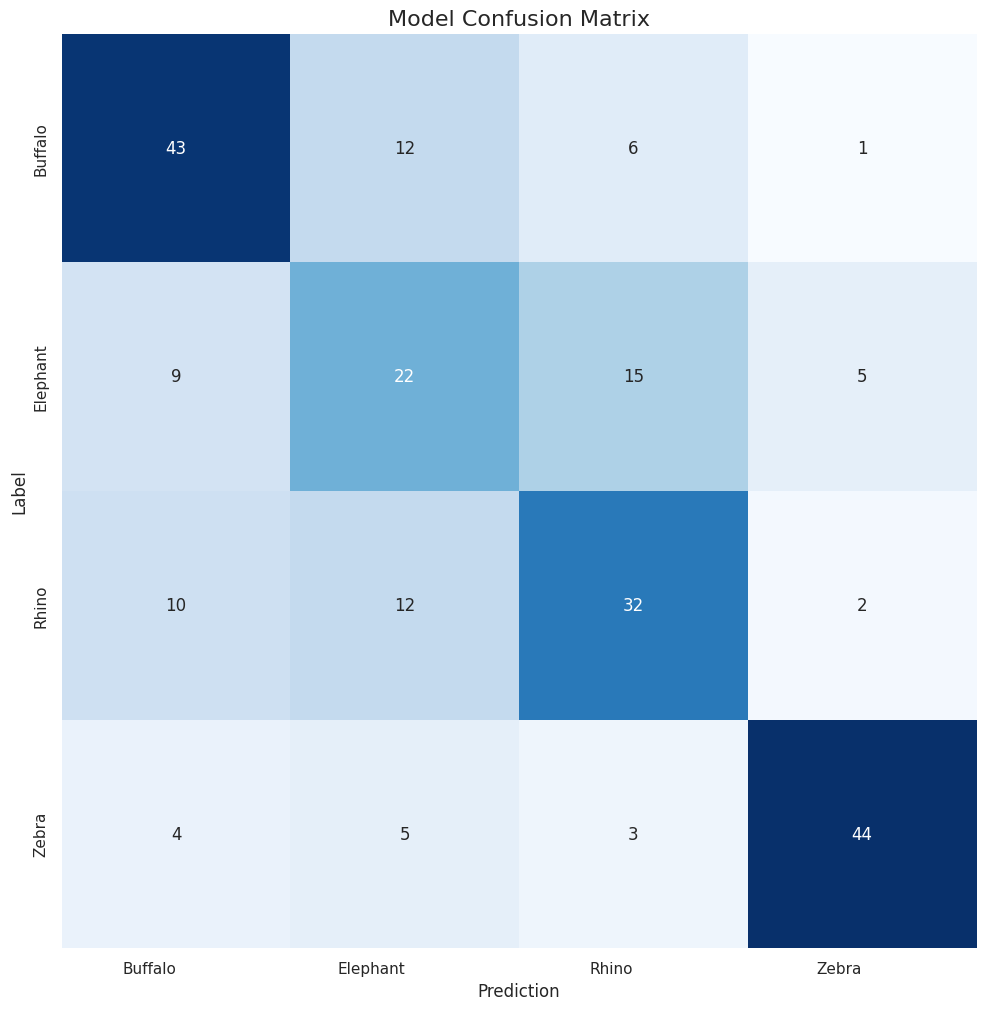

In [166]:
# Make predictions on the test dataset
predictions = loaded_model.predict(valid_images)

# Convert the probability map to class labels
pred_classes = np.argmax(predictions,axis=1)

# Display the confusion matrix
plot_heatmap(valid_labels, pred_classes, classnames, title="Model Confusion Matrix", ylabel='Label', xlabel='Prediction')

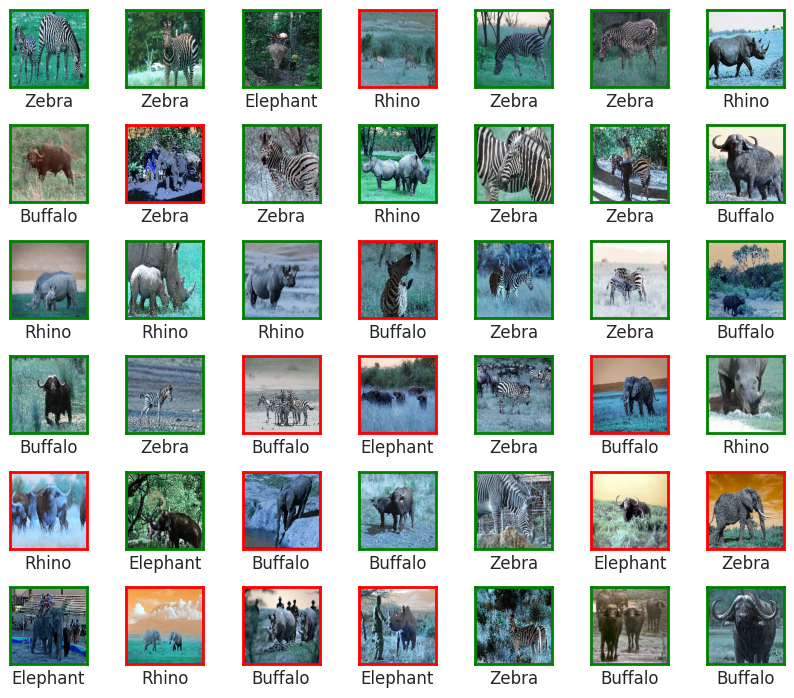

In [158]:
# Display predictions from our model.
# Correct predictions are rendered with green border, and incorrect
# predictions are rendered with red border.
display_predictions(valid_images, valid_labels, classnames, pred_classes, 42, border=2)